<a href="https://www.kaggle.com/code/giuliobenedetti/learning-about-ad?scriptVersionId=157134761" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df_cross = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
df_long = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv")

# Preliminary Exploration

## Data Cleaning

In [2]:
# Rename cols to match names in df_cross
df_long = df_long.rename(columns={"MRI ID": "ID", "EDUC": "Educ", "MR Delay": "Delay"})

# Create columns for easy distinction between the cohorts
df_cross["Cohort"] = "OASIS1"
df_long["Cohort"] = "OASIS2"

# Concatenate df_cross with df_long
df = pd.concat([df_cross, df_long])

# Drop rows with missing target variable
df.dropna(subset=["CDR"], inplace=True)

# Remove cols with only one distinct value
df.drop(["Hand"], axis=1, inplace=True)

# Use ID as row index
df.index = df.pop("ID")

In [3]:
# Binarise target variable
df["CDR"] = df["CDR"].map({0: 0, 0.5: 1, 1: 1, 2: 1, 3: 1})

# Split preprocessed datasets
df_cross = df.loc[df["Cohort"] == "OASIS1", ]
df_long = df.loc[df["Cohort"] == "OASIS2", ]

## Visualisation

With respect to cross-sectional dataset.

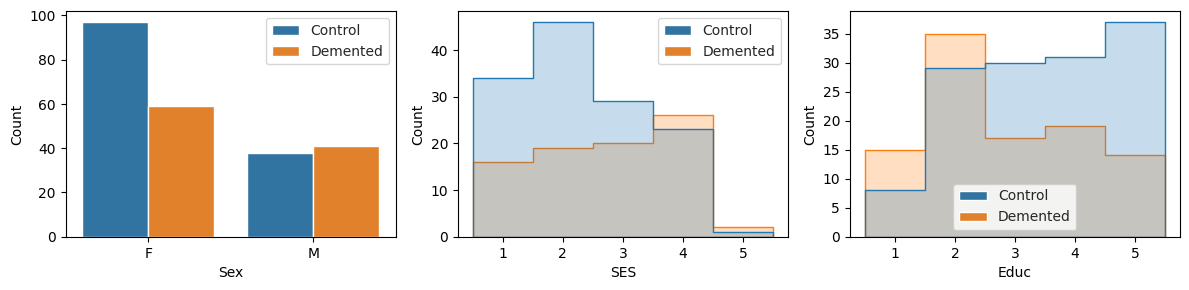

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

df["Visit"] = df["Visit"].fillna(value=1)

ncol = 3
fig, axes = plt.subplots(1, ncol)

fig.set_figheight(3)
fig.set_figwidth(12)
sns.set_style("ticks")

sns.countplot(df_cross, x="M/F", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")


sns.histplot(df_cross, x="SES", hue="CDR", element="step", bins=5, discrete=True, ax=axes[1])
axes[1].set_xticks(range(1, 6))

sns.histplot(df_cross, x="Educ", hue="CDR", element="step", bins=5, discrete=True, ax=axes[2])
axes[2].set_xticks(range(1, 6))

handles, _ = axes[0].get_legend_handles_labels()
labels = dict(zip(["Control", "Demented"], handles))
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())
axes[2].legend(labels.values(), labels.keys(), loc='lower center')

plt.tight_layout()

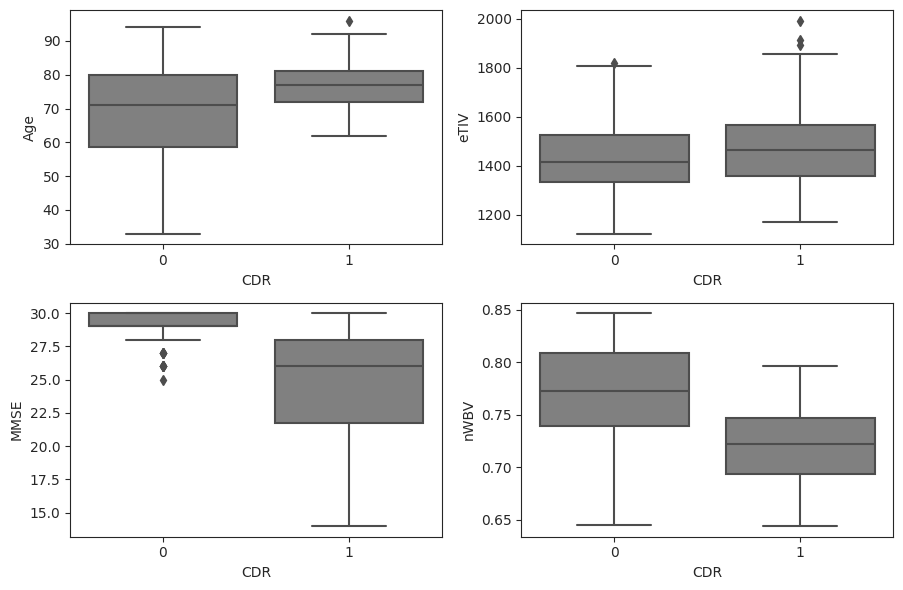

In [5]:
fig, axes = plt.subplots(2, 2)

fig.set_figheight(6)
fig.set_figwidth(9)
sns.set_style("ticks")

sns.boxplot(df_cross, x="CDR", y="Age", color="gray", ax=axes[0, 0])
sns.boxplot(df_cross, x="CDR", y="MMSE", color="gray", ax=axes[1, 0])
sns.boxplot(df_cross, x="CDR", y="eTIV", color="gray", ax=axes[0, 1])
sns.boxplot(df_cross, x="CDR", y="nWBV", color="gray", ax=axes[1, 1])

plt.tight_layout()

With respect to longitudinal dataset.

In [6]:
grouped_df = df_long.groupby(["Visit", "CDR"]).size()
size_arr = df_long.groupby("Visit").size().values

count_df = pd.DataFrame({
    "Visit": [i[0] for i in grouped_df.index],
    "CDR": [i[1] for i in grouped_df.index],
    "Count": grouped_df.values
})

count_df["Percentage"] = count_df["Count"] / count_df["Visit"].map(lambda x: size_arr[round(x) - 1]) * 100

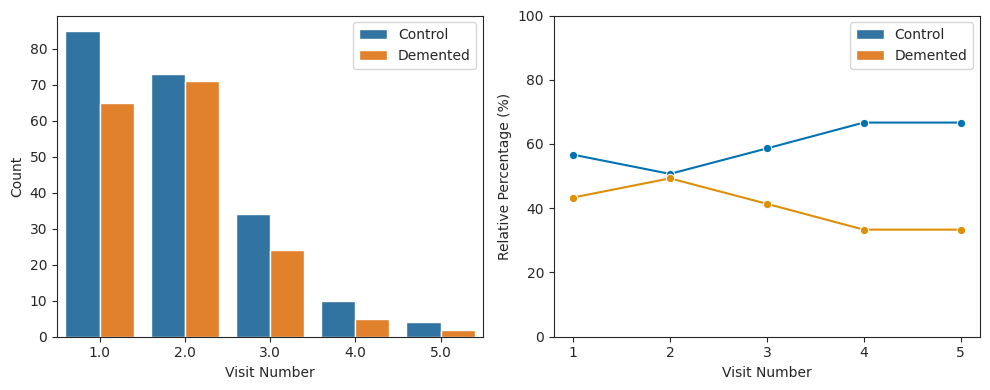

In [7]:
ncol = 2
fig, axes = plt.subplots(1, ncol)

fig.set_figheight(4)
fig.set_figwidth(10)
sns.set_style("ticks")

sns.countplot(df_long, x="Visit", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Visit Number")
axes[0].set_ylabel("Count")

sns.lineplot(
    count_df, x="Visit", y="Percentage",
    hue="CDR", palette="colorblind",
    marker="o", ax=axes[1]
)

axes[1].set_xlabel("Visit Number")
axes[1].set_ylabel("Relative Percentage (%)")
axes[1].set_xticks(range(1, 6))
axes[1].set_ylim(bottom=0, top=100)

handles, _ = axes[0].get_legend_handles_labels()
labels = dict(zip(["Control", "Demented"], handles))
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())

plt.tight_layout()

### Principal Component Analysis

In [8]:
from sklearn.decomposition import PCA
from scipy.stats import mode

# Drop target, categorical variables and metadata
X = df.drop(["Delay", "Subject ID", "Group", "Visit", "M/F", "Cohort"], axis=1)
y = X.pop("CDR")

# Impute SES on the fly
X["SES"] = X["SES"].map(lambda x: mode(X["SES"])[0] if np.isnan(x) else x)
# Impute MMSE on the fly
X["MMSE"] = X["MMSE"].map(lambda x: np.nanmedian(X["MMSE"]) if np.isnan(x) else x)

# Create PCA
pca = PCA(n_components=4)
# Perform PCA
red_dims = pca.fit_transform(X)

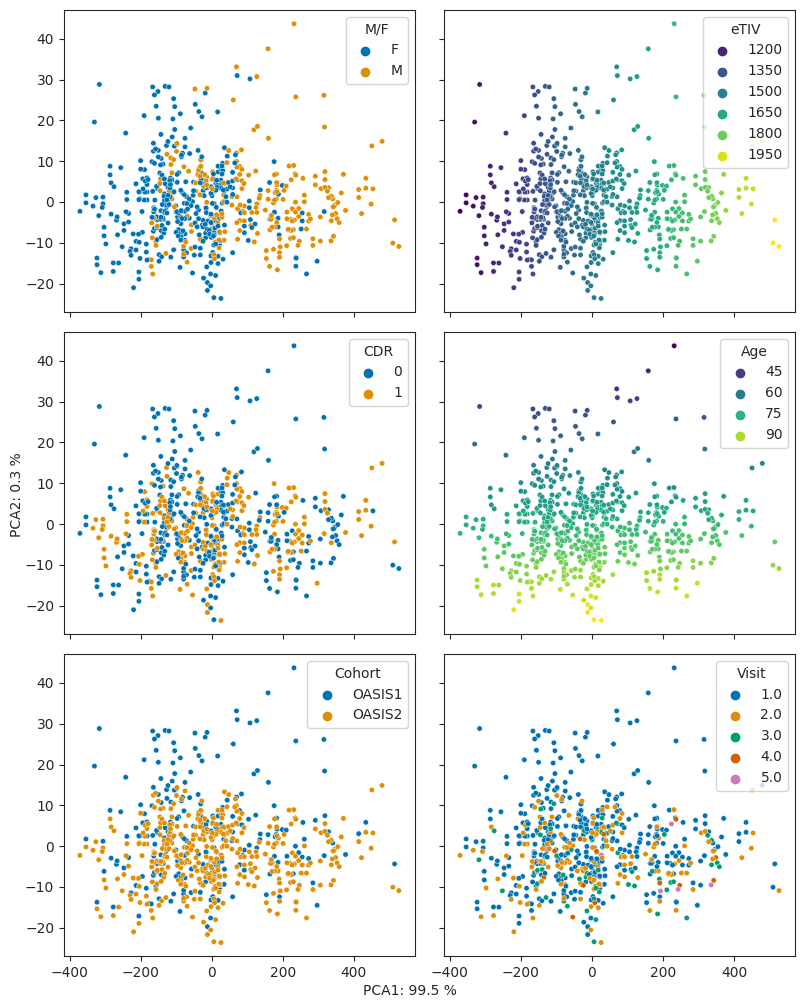

In [9]:
from utilities_for_ad import plot_pca

ncol, nrow = 3, 2
my_palette = sns.color_palette("viridis", as_cmap=True)

fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True)

fig.set_figheight(5 * nrow)
fig.set_figwidth(8)
sns.set_style("ticks")

plot_pca(red_dims, df["M/F"], axes[0, 0])
plot_pca(red_dims, df["eTIV"], axes[0, 1], palette=my_palette)
plot_pca(red_dims, df["CDR"], axes[1, 0])
plot_pca(red_dims, df["Age"], axes[1, 1], palette=my_palette)
plot_pca(red_dims, df["Cohort"], axes[2, 0])
plot_pca(red_dims, df["Visit"], axes[2, 1])

fig.text(0.5, 0, f"PCA1: {pca.explained_variance_ratio_[0] * 100:.1f} %", ha="center")
fig.text(0, 0.5, f"PCA2: {pca.explained_variance_ratio_[1] * 100:.1f} %", va="center", rotation="vertical")

plt.tight_layout()

### Correlation Heatmap

<Axes: >

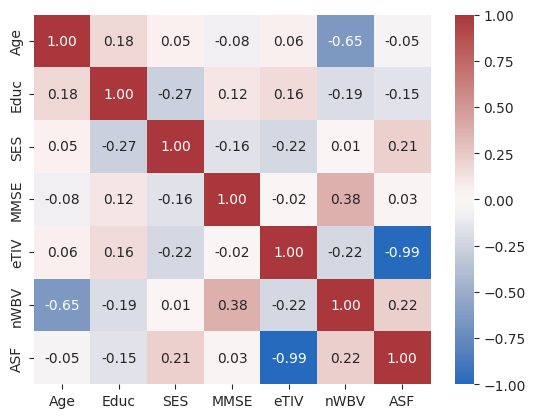

In [10]:
corr = X.corr()
sns.heatmap(
    corr, cmap="vlag", annot=True,
    fmt=".2f", annot_kws={'size': 10},
    vmin=-1, vmax=1
)

### Mutual Information

In [11]:
X["M/F"] = df["M/F"]
discrete_features = ["M/F", "SES", "Educ"]

for col in discrete_features:
    X[col], _ = X[col].factorize()
    
discrete_features = X.dtypes == int

Text(0.5, 0, 'Mutual Information')

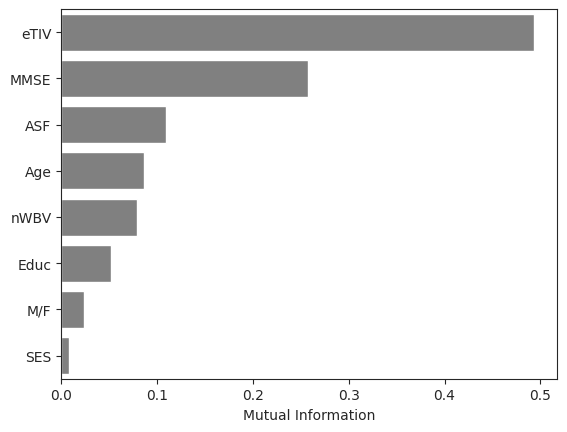

In [12]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

sns.barplot(x=mi_scores, y=mi_scores.index, color="gray")
plt.xlabel("Mutual Information")

# Cross-Sectional Analysis

(expand).

## Preprocessing

train/test split (expand).

In [13]:
from utilities_for_ad import X_y_split
from sklearn import model_selection as ms

# Split X and y for cross-sectional dataset
X_cross, y_cross = X_y_split(df_cross)

# Set fraction of data allocated to the test set 
test_fraction = 0.1

# Split train/devel set from test set
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_cross, y_cross,
    test_size=test_fraction,
    stratify=y_cross,
    random_state=123,
)

Feature Imputation (expand).

In [14]:
from sklearn.impute import SimpleImputer

# Given a uniform distribution, impute SES with mode
ses_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# Given a skewed distribution, impute MMSE with median
mmse_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Apply SES imputer to data
X_train["SES"] = ses_imputer.fit_transform(X_train[["SES"]])
X_test["SES"] = ses_imputer.transform(X_test[["SES"]])

# Apply MMSE imputer to data
X_train["MMSE"] = mmse_imputer.fit_transform(X_train[["MMSE"]])
X_test["MMSE"] = mmse_imputer.transform(X_test[["MMSE"]])

**Data normalisation** helps standardise features and speed up learning. Thus, data is normalised by scaling numerical variables and one-hot encoding categorical ones. Ordinal variables may also need normalisation, but options for this type have not been found yet.

In [15]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

# Categorise variables by type
categorical_vars = ["M/F"]
numerical_vars = ["Age", "Educ", "eTIV", "nWBV", "MMSE"]
ordinal_vars = ["Educ", "SES"]

# Build preprocessor
preprocessor = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_vars),
    (preprocessing.OneHotEncoder(), categorical_vars)
)

# Apply preprocessor to data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Clustering

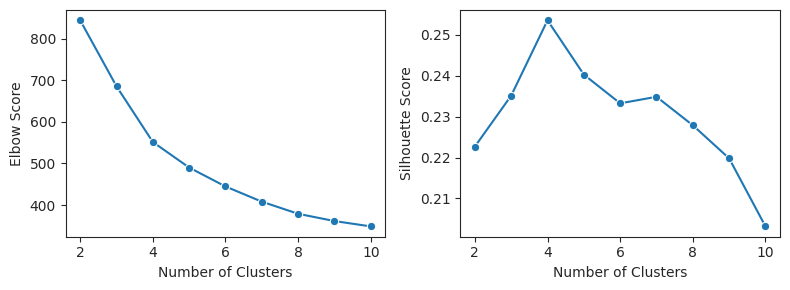

In [16]:
from utilities_for_ad import score_cluster

n_clusters = range(2, 11)
scores = np.array(list(map(lambda n_clusters: score_cluster(X_train, n_clusters), n_clusters)))
elbow, silhouette = scores[:, 0], scores[:, 1]

fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(8)
sns.set_style("ticks")

sns.lineplot(x=n_clusters, y=elbow, marker="o", ax=axes[0])
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Elbow Score")

sns.lineplot(x=n_clusters, y=silhouette, marker="o", ax=axes[1])
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")

plt.tight_layout()

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=123).fit(X_train)
train_clusters = kmeans.labels_.reshape(-1, 1)
test_clusters = kmeans.predict(X_test).reshape(-1, 1)

X_train = np.hstack([X_train, train_clusters])
X_test = np.hstack([X_test, test_clusters])

## Validation Performance

Currently, the criterion to select the most performant model is based on two validation metrics: accuracy and confusion matrix. The former gives a general measure of the classification power, whereas the latter provides a more detailed insight into the bias of the model. It may be useful to validate the models with other metrics which put more weight on the rare classes, that is, the demented subjects.

In [18]:
# Set k equal to the number of occurrences of least populated class
k_folds = 10

# Create stratified K-fold validator
skf = ms.StratifiedKFold(
    n_splits=k_folds,
    shuffle=True,
    random_state=123
)

_What is the minimal performance that we should expect from a model?_ This question can be answered by setting a **baseline performance**. This usually corresponds to the accuracy obtained with a very simple model, such as a classifier that predicts everything to be the most frequent class. The latter approach is applied here to estimate a baseline performance for the cross-sectional and longitudinal datasets as well as the combined dataset.

In [19]:
from utilities_for_ad import baseline_performance
from sklearn.metrics import balanced_accuracy_score

print(f"Baseline accuracy: {baseline_performance(X_cross, y_cross, metric=balanced_accuracy_score):.2f}")

Baseline accuracy: 0.50


The baseline performance remains similar among the three datasets with an average of around 56%. This is the minimum accuracy that we want to achieve with a more suitable model.

## Model Selection

The candidate models include:
- cost-sensitive SVM
- Decision tree
- Random forest
- K neighbours

To add a new model, you can simply import it from a package, create it and store it in the dictionary of classifiers under a name of your choice.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

seed = 123
class_weight = "balanced"

# Prepare empty dictionary to store models
models = {}

# Create SVM classifier and add to dictionary
models["SVM"] = SVC(random_state=seed, class_weight=class_weight)
# Create logistic classifier
models["Logistic Regression"] = LogisticRegression(class_weight=class_weight)
# Create random forest classifier
models["Random Forest"] = RandomForestClassifier(random_state=seed, class_weight=class_weight)
# Create XGBoost classifier
models["Gradient Boosting"] = GradientBoostingClassifier(random_state=seed)
# Create QDA classifier
models["Linear Discriminant"] = LinearDiscriminantAnalysis()
# Create Gaussian classifier
models["Gaussian Process"] = GaussianProcessClassifier(random_state=seed)

### Add new models here ###
# models["name"] = model()

In [21]:
from utilities_for_ad import validate_model, make_confusion_matrix

# Validate models with accuracy
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf).mean(), models.values()))
acc_scores = dict(zip(models.keys(), acc_scores))

# Validate models with a confusion matrix
confusion_matrices = list(map(lambda model: make_confusion_matrix(model, X_train, y_train, cv=skf), models.values()))
confusion_matrices = dict(zip(models.keys(), confusion_matrices))

SVM                 : ACC = 0.823
Logistic Regression : ACC = 0.834
Random Forest       : ACC = 0.838
Gradient Boosting   : ACC = 0.802
Linear Discriminant : ACC = 0.804
Gaussian Process    : ACC = 0.796


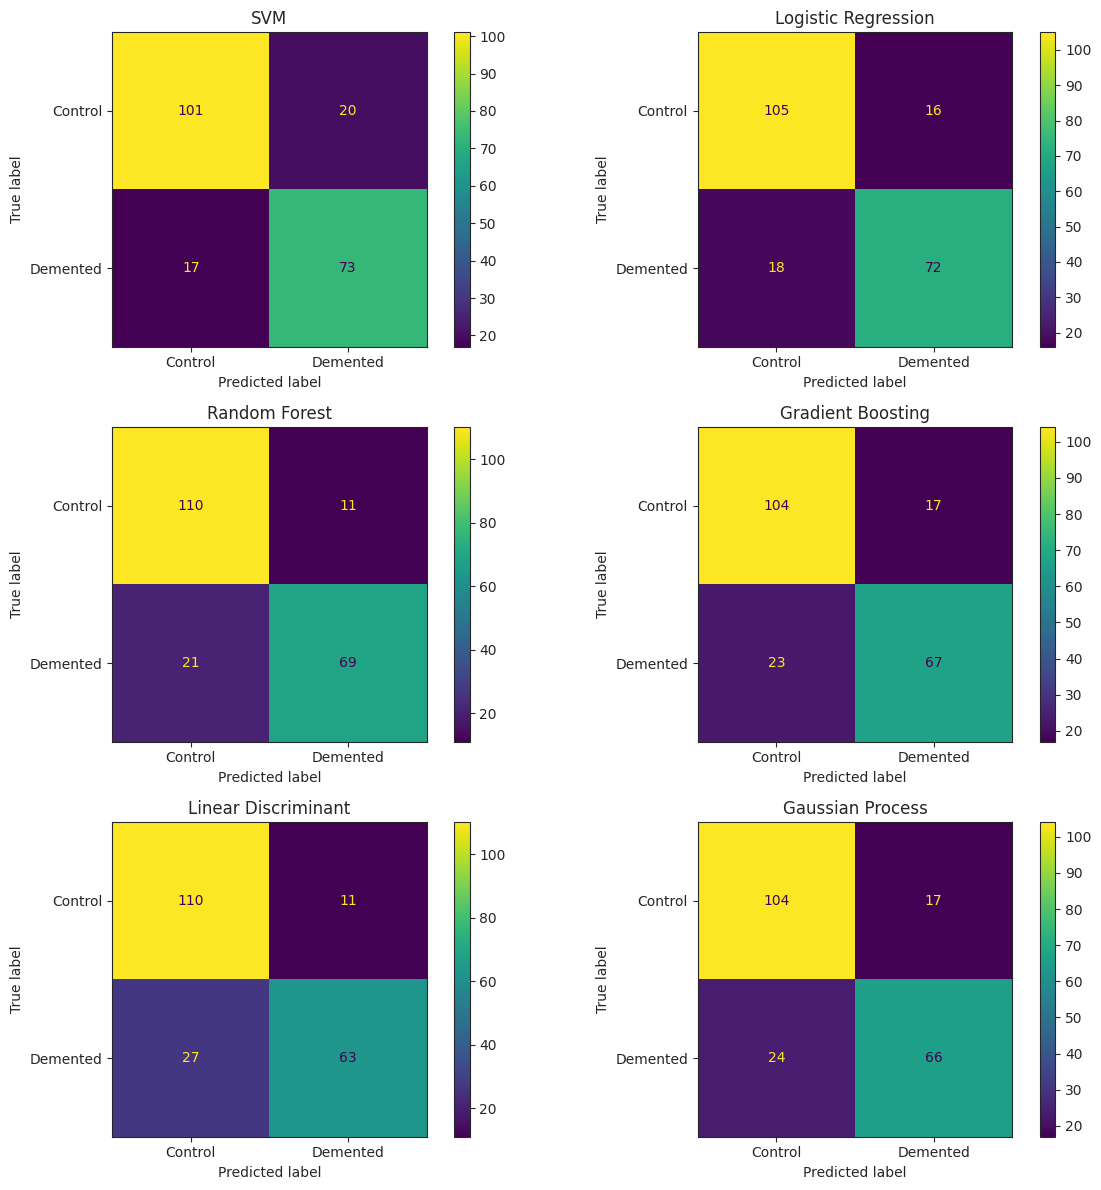

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ncol = 2
model_num = len(models)
nrow = round(np.ceil(model_num / ncol))

fig, axes = plt.subplots(nrow, ncol)

fig.set_figheight(4 * nrow)
fig.set_figwidth(6 * ncol)

# Print validation profile for each model
for idx, (name, model) in enumerate(models.items()):

    print(f"{name:20s}: ACC = {acc_scores[name].mean():.3f}")

    if idx == 0:
        row_idx = 0
    elif idx % ncol == 0:
        row_idx += 1
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[name], display_labels=["Control", "Demented"])
    disp.plot(ax=axes[row_idx, idx % ncol])
    disp.ax_.set_title(name)

plt.tight_layout()

## Hyperparameter Tuning

_How can we optimise the selected model to improve performance?_ The answer to this question lies in **hyperparameter tuning**. Here, the goal consists in finding the combination of values for the model hyperparameters in order to achieve the best possible performance. This is usually done with a grid search, which can be either full or randomised. The former searches over the full grid for the actual best combination, whereas the latter only searches over a random subset of the grid. Randomised grid search reduces the computational demand while still providing a nearly optimal combination of values, for which reason it is applied below.

In [23]:
# Select the best classifier algorithm
selected_key = max(acc_scores, key=acc_scores.get)
selected_model = models[selected_key]

# View the best classifier algorithm
selected_model

RandomForestClassifier(class_weight='balanced', random_state=123)

In [24]:
# Provide parameters to optimise and grid values
if selected_key == "Random Forest":
    
    param_grid = { 
        "n_estimators": [25, 50, 100, 150], 
        "max_features": ["sqrt", "log2", None], 
        "max_depth": [3, 6, 9], 
        "max_leaf_nodes": [3, 6, 9], 
    } 
    
elif selected_key == "SVM":
    
    param_grid = {
        "C": [1, 10, 100, 1000],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4, 5],
        "gamma": ["auto", "scale"]
    }

elif selected_key == "Logistic Regression":
    
    param_grid = {
        "penalty": ["l1", "l2"], 
        "C":[1, 2, 5, 10, 100, 1000]
    }   

In [25]:
from sklearn.metrics import make_scorer
from functools import reduce

# Convert parameter grid to list
grid_values = list(param_grid.values())
# Compute number of possible combinations (full grid)
full_search_iter = reduce(lambda x, y: x * len(y), grid_values[1:], len(grid_values[0]))

# Perform randomised search for best combination of parameters
tuned_models = ms.RandomizedSearchCV(
    estimator=selected_model,
    param_distributions=param_grid,
    n_iter=min(full_search_iter, 60), 
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf,
    random_state=123
)

In [26]:
# Train tuned models
tuned_models.fit(X_train, y_train)

# Select the best model in terms of accuracy
tuned_model = tuned_models.best_estimator_

# View the best model
tuned_model

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                       max_leaf_nodes=6, n_estimators=25, random_state=123)

## Model Assessment

After selecting and tuning the best model, it is finally time to test its performance on the test set. Getting nervous, how well will it do?

Accuracy of best tuned model: 0.757


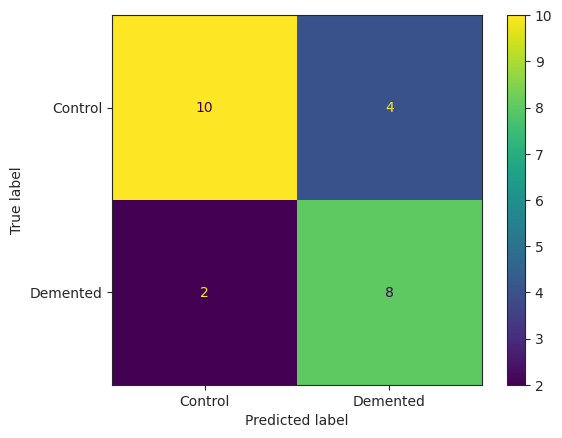

In [27]:
# Predict CDR of test set with best tuned model
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

print(f"Accuracy of best tuned model: {balanced_accuracy_score(y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
disp.plot()

### Deep Learning Approach

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utilities_for_ad import reproduce_environment

# Set input shape
input_shape = [X_train.shape[1]]

# Build model
def design_model():
    
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(4, activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(4, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(1, activation="sigmoid")
    ])

    return model

In [29]:
# Initialise empty lists
train_accuracies = []
devel_accuracies = []

# Perform 10-fold cross-validation
for train_index, devel_index in skf.split(X_train, y_train):
    
    # Subset train and devel sets
    train_subset = X_train[train_index]
    train_labels = y_train[train_index]
    devel_subset = X_train[devel_index]
    devel_labels = y_train[devel_index]
    
    # Make environment reproducible
    reproduce_environment(random_state=123)
    
    # Build model
    model = design_model()
    
    # Compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["binary_accuracy"]
    )
    
    # Train model
    history = model.fit(
        train_subset, train_labels,
        validation_data=(devel_subset, devel_labels),
        epochs=100,
        batch_size=20,
        verbose=False
    )
    
    # Fetch accuracy
    history_df = pd.DataFrame(history.history)
    
    train_accuracies.append(history_df['binary_accuracy'].iloc[-1])
    devel_accuracies.append(history_df['val_binary_accuracy'].iloc[-1])
    
    print(f"Train accuracy: {train_accuracies[-1]:.3f}, Devel accuracy: {devel_accuracies[-1]:.3f}")  

Train accuracy: 0.820, Devel accuracy: 0.727
Train accuracy: 0.768, Devel accuracy: 0.762
Train accuracy: 0.784, Devel accuracy: 0.905
Train accuracy: 0.758, Devel accuracy: 0.762
Train accuracy: 0.758, Devel accuracy: 0.857
Train accuracy: 0.779, Devel accuracy: 0.762
Train accuracy: 0.768, Devel accuracy: 0.857
Train accuracy: 0.768, Devel accuracy: 0.905
Train accuracy: 0.737, Devel accuracy: 0.810
Train accuracy: 0.747, Devel accuracy: 0.810


In [30]:
# Make environment reproducible
reproduce_environment(random_state=123)

# Build model
model = design_model()
    
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["binary_accuracy"]
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=20,
    verbose=False
)

history_df = pd.DataFrame(history.history)
print(f"Train accuracy: {history_df['binary_accuracy'].iloc[-1]:.3f}, Test accuracy: {history_df['val_binary_accuracy'].iloc[-1]:.3f}")

Train accuracy: 0.806, Test accuracy: 0.750


<Axes: title={'center': 'Accuracy'}>

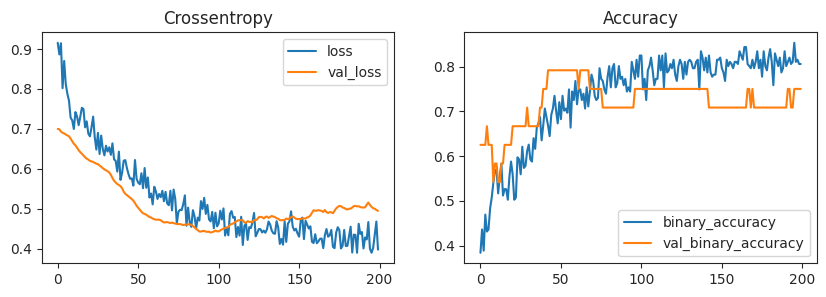

In [31]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(title="Accuracy", ax=axes[1])

1/1 [==============================] - 0s 159ms/step
Accuracy of neural network: 0.757


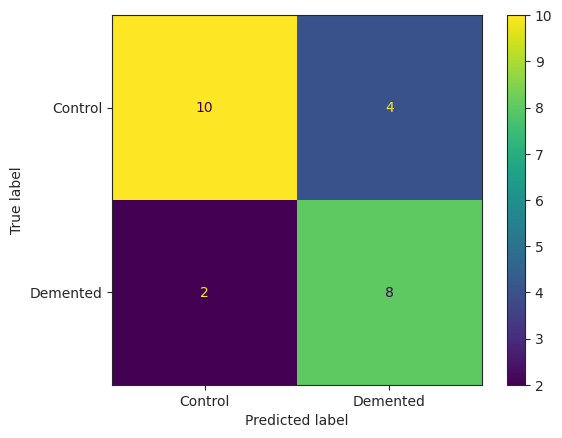

In [32]:
# Predict labels
y_pred = model.predict(X_test) >= 0.5
y_pred = y_pred.astype(int)

print(f"Accuracy of neural network: {balanced_accuracy_score(y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
dist = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
dist.plot()

## Conclusions

In [33]:
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf), models.values()))

eval_df = pd.DataFrame(acc_scores, index=models.keys())

eval_df.loc[len(eval_df)] = devel_accuracies
eval_df.rename(index={len(eval_df) - 1: "Neural Network"}, inplace=True)

eval_df["Classifier"] = eval_df.index
eval_df = pd.melt(eval_df, id_vars="Classifier", value_vars=range(k_folds))

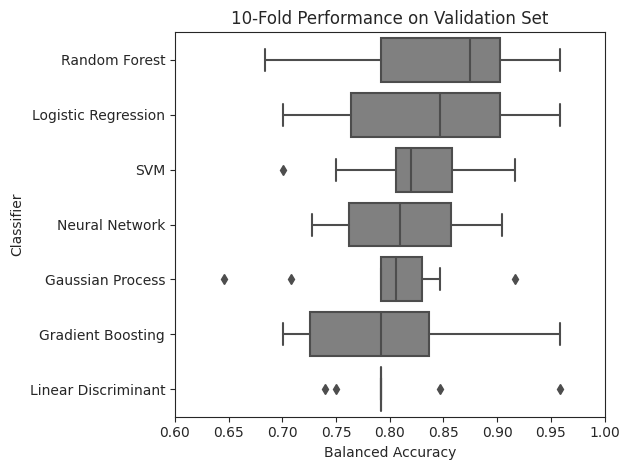

In [34]:
medians = eval_df.groupby(["Classifier"])["value"].median().sort_values(ascending=False)

sns.boxplot(eval_df, y="Classifier", x="value", color="gray", order=medians.index)

plt.title("10-Fold Performance on Validation Set")
plt.xlim([0.6, 1])
plt.xlabel("Balanced Accuracy")

plt.tight_layout()

# Longitudinal Analysis

In [35]:
'''sub_df = df_long.pivot(
    index="Subject ID",
    columns="Visit",
    values="CDR"
)

sub_df["NetChange"] = sub_df.ffill(axis=1).diff(axis=1).abs().sum(axis=1)
sub_df["Attended"] = 5 - sub_df.isna().sum(axis=1)
sub_df["InitialCDR"] = sub_df.iloc[:, 0]
sub_df.reset_index(inplace=True)'''

'sub_df = df_long.pivot(\n    index="Subject ID",\n    columns="Visit",\n    values="CDR"\n)\n\nsub_df["NetChange"] = sub_df.ffill(axis=1).diff(axis=1).abs().sum(axis=1)\nsub_df["Attended"] = 5 - sub_df.isna().sum(axis=1)\nsub_df["InitialCDR"] = sub_df.iloc[:, 0]\nsub_df.reset_index(inplace=True)'

In [36]:
'''X_train, X_test = ms.train_test_split(
    sub_df,
    test_size=0.1,
    stratify=sub_df[["InitialCDR", "NetChange"]],
    random_state=123
)

X_train = pd.melt(
    X_train,
    id_vars=["Subject ID"],
    value_vars=[1.0, 2.0, 3.0, 4.0, 5.0]
)

X_test = pd.melt(
    X_test,
    id_vars=["Subject ID"],
    value_vars=[1.0, 2.0, 3.0, 4.0, 5.0]
)'''

#tscv = ms.TimeSeriesSplit()

'X_train, X_test = ms.train_test_split(\n    sub_df,\n    test_size=0.1,\n    stratify=sub_df[["InitialCDR", "NetChange"]],\n    random_state=123\n)\n\nX_train = pd.melt(\n    X_train,\n    id_vars=["Subject ID"],\n    value_vars=[1.0, 2.0, 3.0, 4.0, 5.0]\n)\n\nX_test = pd.melt(\n    X_test,\n    id_vars=["Subject ID"],\n    value_vars=[1.0, 2.0, 3.0, 4.0, 5.0]\n)'

In [37]:
#sum(df_long.groupby("Subject ID")["Age"].nunique() > 1)
#X = df_long.drop(["Group"])

'''df_long["Visit"] = df_long["Visit"].astype(str)

stable_vars = ["M/F", "SES", "Educ"]



X = df_long.pivot(
    index="Subject ID",
    columns="Visit",
    values=["Age", "MMSE", "eTIV", "nWBV", "ASF", "Delay"]
)

X.reset_index(inplace=True)'''

'df_long["Visit"] = df_long["Visit"].astype(str)\n\nstable_vars = ["M/F", "SES", "Educ"]\n\n\n\nX = df_long.pivot(\n    index="Subject ID",\n    columns="Visit",\n    values=["Age", "MMSE", "eTIV", "nWBV", "ASF", "Delay"]\n)\n\nX.reset_index(inplace=True)'

In [38]:
'''X.columns = [' '.join(col).strip() for col in X.columns.values]
X.columns = [" ".join(col).strip(".0| ") for col in X.columns]
X.index = X.pop("Subject ID")
X'''

'X.columns = [\' \'.join(col).strip() for col in X.columns.values]\nX.columns = [" ".join(col).strip(".0| ") for col in X.columns]\nX.index = X.pop("Subject ID")\nX'

In [39]:
'''model = keras.Sequential([
    layers.GRU(256, input_shape=(1, features), return_sequences=True),
    layers.Dropout(rate=0.25),
    layers.LSTM(256),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])'''

'model = keras.Sequential([\n    layers.GRU(256, input_shape=(1, features), return_sequences=True),\n    layers.Dropout(rate=0.25),\n    layers.LSTM(256),\n    layers.Dropout(0.25),\n    layers.Dense(64, activation="relu"),\n    layers.Dense(1, activation="sigmoid")\n])'